# Timon Spichtinger Machine Learning 2 Modularbeit

In [1]:
from torchvision.datasets import EMNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch
import importlib


from Datensatz import get_emnist_test_train, show_random_samples

In [2]:
X_train, y_train, X_test, y_test,classlist = get_emnist_test_train()




Ziel-ASCII: [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]
Anzahl Zielklassen: 36
⚠️ Klasse B: nur 3878 echte Bilder – augmentiere 2122 zusätzlich.
⚠️ Klasse D: nur 4562 echte Bilder – augmentiere 1438 zusätzlich.
⚠️ Klasse E: nur 4934 echte Bilder – augmentiere 1066 zusätzlich.
⚠️ Klasse G: nur 2517 echte Bilder – augmentiere 3483 zusätzlich.
⚠️ Klasse H: nur 3152 echte Bilder – augmentiere 2848 zusätzlich.
⚠️ Klasse J: nur 3762 echte Bilder – augmentiere 2238 zusätzlich.
⚠️ Klasse K: nur 2468 echte Bilder – augmentiere 3532 zusätzlich.
⚠️ Klasse L: nur 5076 echte Bilder – augmentiere 924 zusätzlich.
⚠️ Klasse b: nur 5159 echte Bilder – augmentiere 841 zusätzlich.
⚠️ Klasse c: nur 2854 echte Bilder – augmentiere 3146 zusätzlich.
⚠️ Klasse f: nur 2561 echte Bilder – augmentiere 3439 zusätzlich.
⚠️ Klasse g: nur 3687 echte Bilder – augmentiere 2313 zusätzlich.
⚠️ Klasse i: nur 272

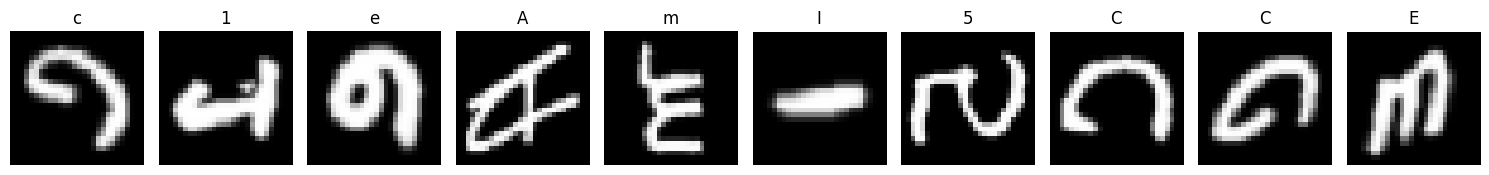

In [3]:

show_random_samples(X_test, y_test, classlist, n=10)

In [4]:
classlist

[48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import datasets
from torchvision.transforms import ToTensor, RandomAffine, Compose
from PIL import Image
from collections import defaultdict
from Klassifikator import AlexNet , ResNet18

# -----------------------------
# Geräte-Konfiguration & Hyperparameter
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 30
batch_size = 64
initial_lr = 0.1  # Anfangslernrate

# -----------------------------
# Klassenliste (direkte Labels)
# -----------------------------
class_list = list('0123456789ABCDEFGHIJKLMabcdefghijklm')  # 36 Zeichen

# -----------------------------
# CNN-Modell
# -----------------------------
class ConvNet(nn.Module):
    def __init__(self,class_list):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, len(class_list))  # 36 Klassen

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # [B, 6, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))   # [B, 16, 5, 5]
        x = x.view(-1, 16 * 5 * 5)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x
# -----------------------------
# Lade Daten (angenommen du hast X_train, y_train, X_test, y_test vorher vorbereitet)
# -----------------------------
def transform_to_rgb_and_resize(tensor_batch):
    return torch.stack([transforms.Resize((32, 32))(img.repeat(3, 1, 1)) for img in tensor_batch])

# Wandelt Graustufen-Bilder in 3-Kanal-RGB um und resized sie auf 32x32
X_train = transform_to_rgb_and_resize(X_train)
X_test = transform_to_rgb_and_resize(X_test)

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# -----------------------------
# Training
# -----------------------------
model = ResNet18(len(class_list)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)  

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    scheduler.step()
    print(f'🔁 Epoch {epoch+1} abgeschlossen. Durchschnittlicher Loss: {running_loss / len(train_loader):.4f}')

print("✅ Training abgeschlossen.")

# -----------------------------
# Modell speichern
# -----------------------------
torch.save(model.state_dict(), './emnist_cnn.pth')

# -----------------------------
# Modell testen
# -----------------------------
model.eval()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = defaultdict(int)
    n_class_samples = defaultdict(int)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(labels.size(0)):
            label = labels[i].item()
            pred = predicted[i].item()
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Gesamtgenauigkeit des Netzwerks: {acc:.2f} %')

    for label in sorted(n_class_samples.keys()):
        ascii_char = class_list[label]
        acc = 100.0 * n_class_correct[label] / n_class_samples[label]
        print(f'Genauigkeit für Klasse {ascii_char}: {acc:.2f} %')


Epoch [1/30], Step [200/2813], Loss: 1.7912
Epoch [1/30], Step [400/2813], Loss: 1.6252
Epoch [1/30], Step [600/2813], Loss: 1.1332
Epoch [1/30], Step [800/2813], Loss: 1.2700
Epoch [1/30], Step [1000/2813], Loss: 0.8271
Epoch [1/30], Step [1200/2813], Loss: 1.0073
Epoch [1/30], Step [1400/2813], Loss: 1.3557
Epoch [1/30], Step [1600/2813], Loss: 1.4655
Epoch [1/30], Step [1800/2813], Loss: 1.3414
Epoch [1/30], Step [2000/2813], Loss: 1.6087
Epoch [1/30], Step [2200/2813], Loss: 1.6142
Epoch [1/30], Step [2400/2813], Loss: 1.6908
Epoch [1/30], Step [2600/2813], Loss: 1.9006
Epoch [1/30], Step [2800/2813], Loss: 2.6105
🔁 Epoch 1 abgeschlossen. Durchschnittlicher Loss: 1.5583
Epoch [2/30], Step [200/2813], Loss: 2.5368
Epoch [2/30], Step [400/2813], Loss: 1.8526


KeyboardInterrupt: 

In [ ]:
X_test[0].shape

torch.Size([3, 32, 32])